In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob 

d:\projects\eco-driving_powertrainOpt\.venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<Figure size 2000x800 with 0 Axes>

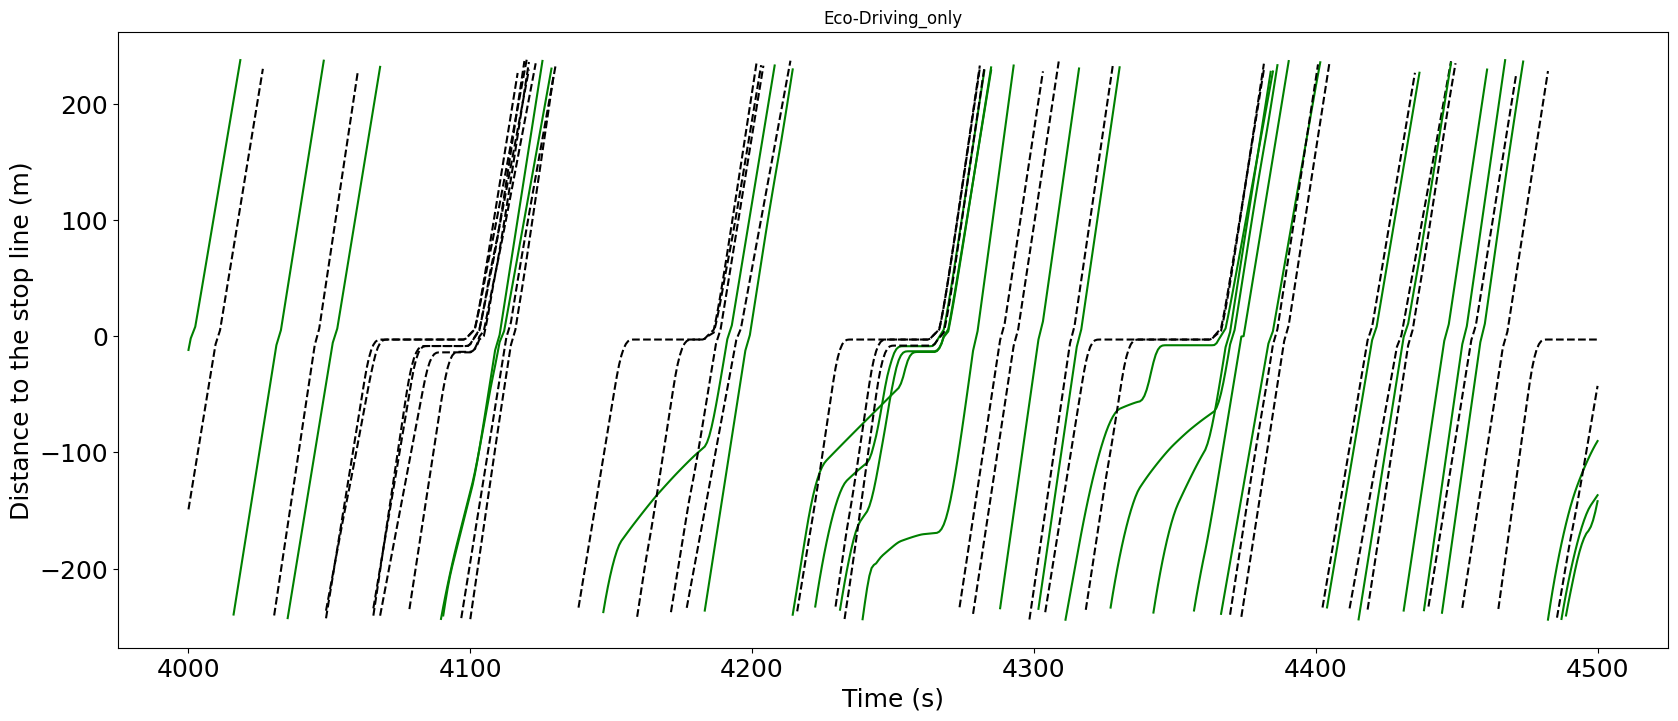

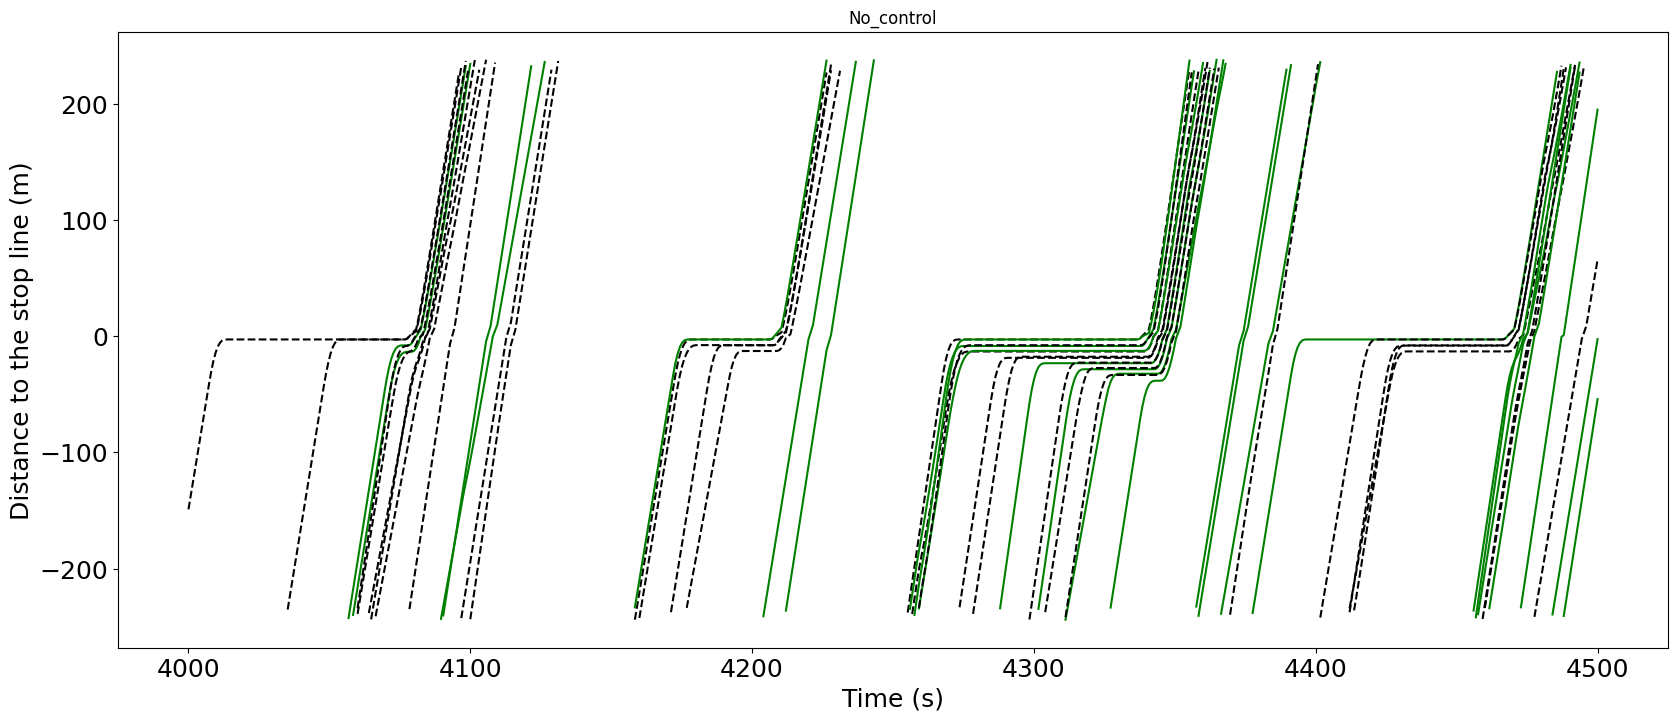

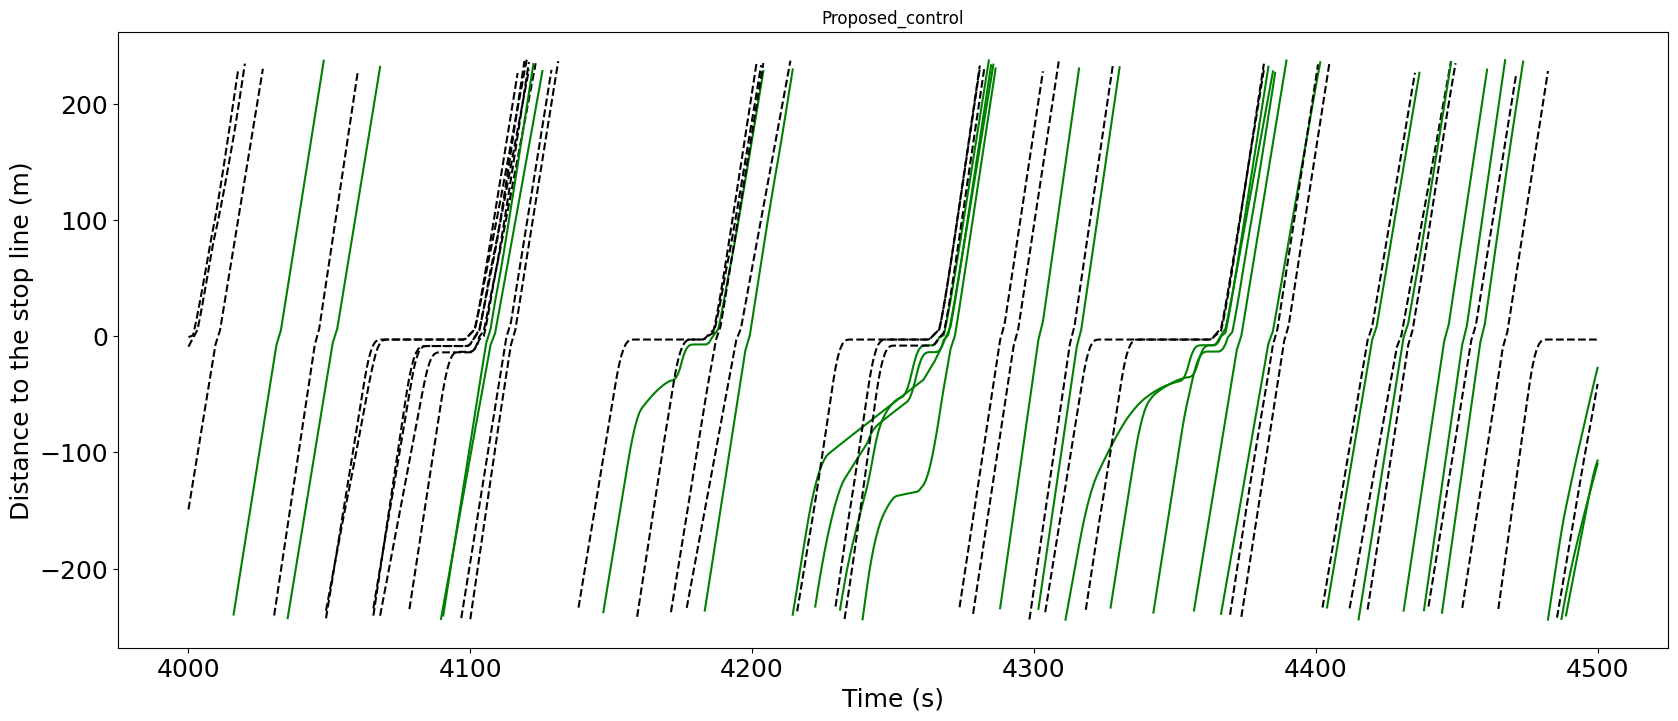

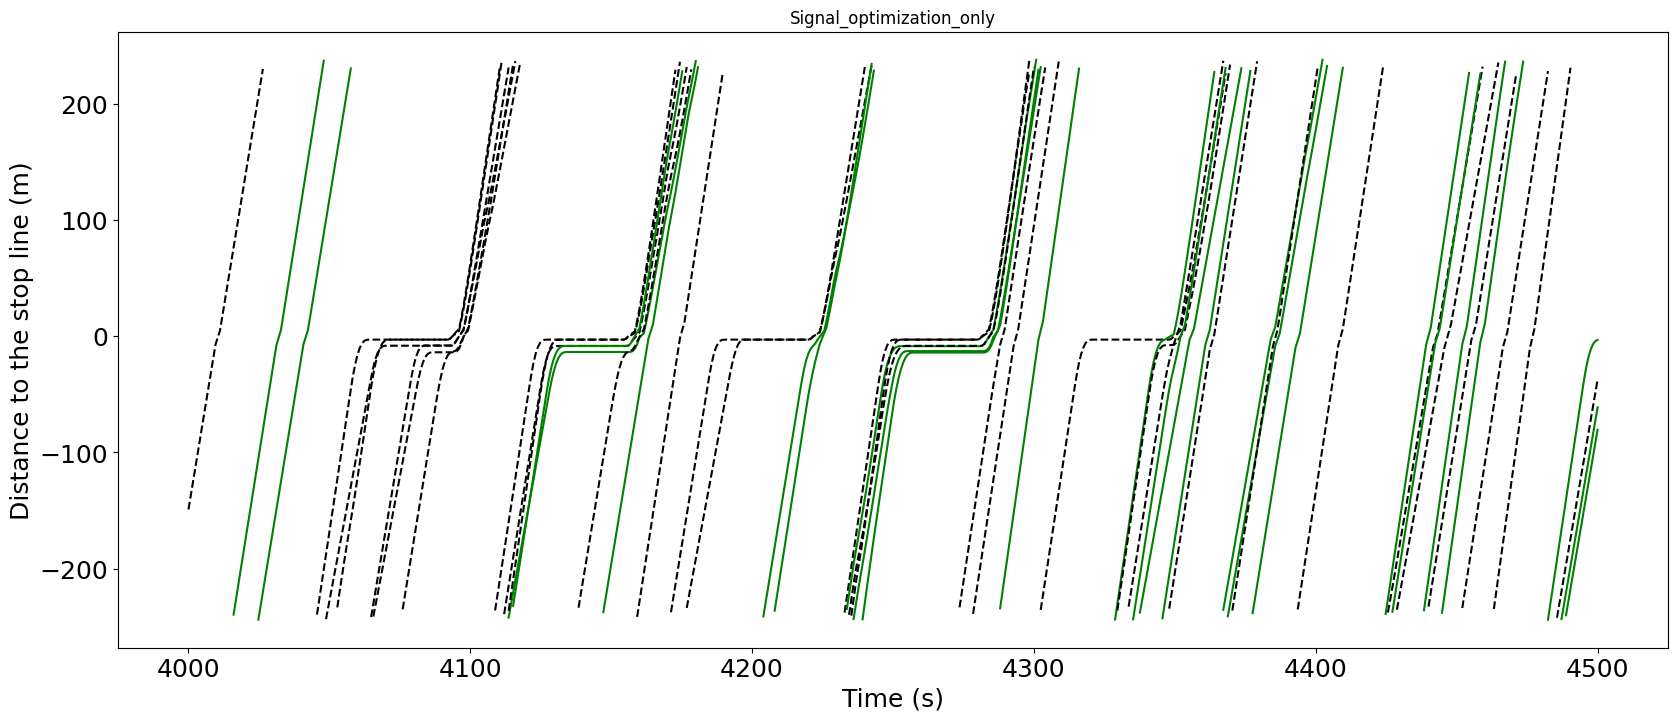

In [3]:
control_method = ["No_control", "Signal_optimization_only", "Eco-Driving_only", "Proposed_control"]
file_list = glob.glob('results/*.csv')
plot_sec_id = [1249, 1252] # plot distance vs time
numlane = [1, 2, 3]
plot_demand_percent = 10
plot_cav_percent = 50
plot_veh_idx = 50 # plot the i^th vehicle (speed vs. time), this is not vehicle id
num_control_plotted = 0 # indicate how many control strategies have been plotted

## vehicle type ID
# ICEV_CAV = 5380,
# ICEV_NON_CAV = 154,
# BEV_CAV = 5591,
# BEV_NON_CAV = 5590,
# HEV_CAV = 5596,
# HEV_NON_CAV = 5597,
# PHEV_CAV = 5592,
# PHEV_NON_CAV = 5593,
# HFCV_CAV = 5594,
# HFCV_NON_CAV = 5595
control_vehicle_type_id = 5380
non_control_vehicle_type_id = 154
# section id for the control node
section_dict = {'1249': [1252, 5325], '1272': [1270, 1784]}
control_sections_list = [int(i) for i in section_dict.keys()]


def fig_plot(control_idx, control_method, target_vehicle_trajctory):
    
    if control_idx == control_method[0]:
        color = 'k'
    elif control_idx == control_method[1]:
        color = 'r--'
    elif control_idx == control_method[2]:
        color = 'b'
    elif control_idx == control_method[3]:
        color = 'g'
    
    time = range(len(target_vehicle_trajctory['CurrentSpeed']))
    plt.plot(time, target_vehicle_trajctory['CurrentSpeed'], color)
    plt.xlabel('Time (s)', fontdict={'size':18, 'color':'black'})
    plt.ylabel('Speed (km/h)', fontdict={'size': 18})
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)

min_travel_time = 0 # initialize the minimum travel time among trajectories of four control strategies, the minimum travel time is used as the x-coordinates to plot
plt.figure(figsize=(20,8))
for item in file_list:
    control_idx = item[8:item.find("_demand")]
    subname_1 = item[item.find('demand')+6:]
    demand_percent = int(subname_1[0:subname_1.find("_C")])
    subname_2 = item[item.find("CAV")+3:]
    cav_percent = int(subname_2[0:subname_2.find("_")])
    repli_id = subname_2[subname_2.find("_")+1:subname_2.find(".")] # last four digits are replication id

    # plot trajectory results only for one replication, CAV 10% and demand 10% under each control strategy
    if demand_percent == plot_demand_percent and cav_percent == plot_cav_percent:
        trajectory = pd.read_csv(item, delimiter='\t')
        
        # # plot speed versus time
        # cav_trajectory = trajectory[trajectory['veh_type_id'] == control_vehicle_type_id]
        # cav_ids = cav_trajectory['vehicle_id'].unique()

        # cnt_cav = 0 # control the id of the vehicle to be visualized

        # if num_control_plotted == 0: # plot the 1st control strategy
        #     for veh_idx in cav_ids:
        #         cnt_cav += 1
        #         if cnt_cav == plot_veh_idx:

        #             target_vehicle_trajctory = cav_trajectory[cav_trajectory['vehicle_id'] == veh_idx]
        #             empty_check = target_vehicle_trajctory['section_id'].isin(control_sections_list)
                    
        #             if target_vehicle_trajctory[empty_check].empty: # remove those only on upstream or downstream sections
        #                 plot_veh_idx += 1 # if this vehicle only appears on downstream sections, remove it and move to plot the next vehicle
        #                 continue
        #             else:
        #                 print(veh_idx)
        #                 fig_plot(control_idx, control_method, target_vehicle_trajctory)
        #                 pre_veh_idx = veh_idx 
        #                 num_control_plotted += 1
        #                 break
        # else:
        #     for veh_idx in cav_ids:
        #         if veh_idx == pre_veh_idx:
        #             target_vehicle_trajctory = cav_trajectory[cav_trajectory['vehicle_id'] == veh_idx]
        #             empty_check = target_vehicle_trajctory['section_id'].isin(control_sections_list)
                    
        #             if target_vehicle_trajctory[empty_check].empty: # remove those only on upstream or downstream sections
        #                 plot_veh_idx += 1 # if this vehicle only appears on downstream sections, remove it and move to plot the next vehicle
        #                 continue
        #             else:
        #                 print(veh_idx)
        #                 fig_plot(control_idx, control_method, target_vehicle_trajctory)
        #                 break

                
        # plot distance versus time
        filter_trajctory_by_time = trajectory[trajectory['simulation_time'].between(4000, 4500)]
        vehicle_id = filter_trajctory_by_time.vehicle_id.unique()

        for col_section, downstream_section in section_dict.items():
            col_section = int(col_section)
            # all distance2End on control sections should be multiplied by -1 to ensure vehicles trajectories go upward in the figure
            filter_trajctory_by_time.loc[filter_trajctory_by_time['section_id']==col_section, 'distance2End'] *= -1
        
        
        reduced_trajectory = filter_trajctory_by_time[filter_trajctory_by_time.section_id.isin(plot_sec_id)]

        plt.figure(figsize=(20,8))

        for veh_id in vehicle_id:
            veh_id_df = reduced_trajectory[reduced_trajectory.vehicle_id == veh_id].sort_values('simulation_time')

            if veh_id_df['section_id'] not in np.array(plot_sec_id[0]): # do not plot trajectories for those which do not travel from the control section
                continue
            
            if control_vehicle_type_id in veh_id_df['veh_type_id'].unique():
                color = 'g'
            else:
                color = 'k--'
            
            veh_id_df = veh_id_df[veh_id_df['numberLane'].isin(numlane)]
            # error_check = error_check.append(veh_id_df)
            time = veh_id_df['simulation_time']
            plt.plot(time, veh_id_df['distance2End'], color)
            plt.xlabel('Time (s)', fontdict={'size':18, 'color':'black'})
            plt.ylabel('Distance to the stop line (m)', fontdict={'size': 18})
            plt.title(str(control_idx))
            plt.xticks(fontsize = 18)
            plt.yticks(fontsize = 18)

